### CREDIT

This notebook is prepared by the guidance of  Margaret Maynard-Reid's blogs from Pyimagesearch. Most of the code blocks and explanations are taken from these blogs. You can reach original codes and detailed explanations from references.

#### WHAT IS THIS NOTEBOOK

This notebook is an example about WGAN nad WGANGP by keras and TF. We will implement WGAN for Anime Face Dataset from Kaggle , based on the paper Wasserstein GAN(M.Arjovsky,2017)


#### Keywords

* WGAN
* WGANGP
* GAN
* TF 
* Anime Face Dataset from Kaggle

In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
from matplotlib import pyplot as plt

In [2]:
dataset=r'C:\Users\Zeki\Desktop\kisisel calismalar\datasets\anime'

!!!! original batch size is 256 but my pc can't handle it...

In [25]:
train_images = tf.keras.utils.image_dataset_from_directory(
    dataset, label_mode=None, image_size=(64, 64), batch_size=128)

Found 63565 files belonging to 1 classes.


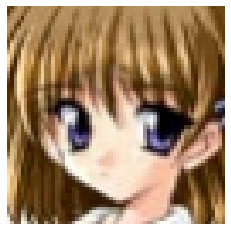

In [4]:
image_batch = next(iter(train_images))
random_index = np.random.choice(image_batch.shape[0])
random_image = image_batch[random_index].numpy().astype("int32")

# Visualize 1 random image from the training dataset
plt.axis("off")
plt.imshow(random_image)
plt.show()

In [5]:
def show(images):
    plt.figure(figsize=(4, 4))

    for i in range(16):
        plt.subplot(4, 4, i+1)
        img = keras.utils.array_to_img(images[i]) 
        plt.imshow(img)
        plt.axis('off') 
    plt.show()

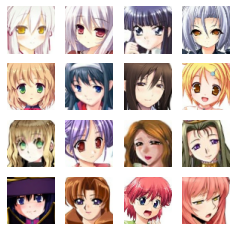

In [6]:
# Visualize 16 images from the training dataset
show(image_batch[:16])

In [7]:
# Normalize the images to [-1, 1] which is the range of the tanh activation
train_images = train_images.map(lambda x: (x - 127.5) / 127.5)

In [8]:
# latent dimension of the random noise
LATENT_DIM = 128 
# weight initializer for G per DCGAN paper 
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02) 
# number of channels, 1 for gray scale and 3 for color images
CHANNELS = 3  

In [9]:
def build_generator():
    # create a Keras Sequential model 
    model = Sequential(name="generator")

    # prepare for reshape: FC => BN => RN layers, note: input shape defined in the 1st Dense layer  
    model.add(layers.Dense(8 * 8 * 512, input_dim=LATENT_DIM))
    # model.add(layers.BatchNormalization()) 
    model.add(layers.ReLU())
    # layers.LeakyReLU(alpha=0.2),

    # 1D => 3D: reshape the output of the previous layer 
    model.add(layers.Reshape((8, 8, 512)))

    # upsample to 16x16: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(256, (4, 4), 
                                     strides=(2, 2), 
                                     padding="same", 
                                     use_bias=False, 
                                     kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization()) # Margaret exp: add back bach norm
    model.add((layers.ReLU()))

    # upsample to 32x32: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(128, (4, 4), 
                                     strides=(2, 2), 
                                     padding="same", 
                                     use_bias=False, 
                                     kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization()) # Margaret exp: add back bach norm
    model.add((layers.ReLU()))

    # upsample to 64x64: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(64, (4, 4), 
                                     strides=(2, 2), 
                                     padding="same", 
                                     use_bias=False, 
                                     kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization()) # Margaret exp: add back bach norm
    model.add((layers.ReLU()))

    # final layer: Conv2D with tanh activation
    model.add(layers.Conv2D(CHANNELS, (4, 4), padding="same", activation="tanh"))

    # return the generator model
    return model

In [10]:
# build the generator model
generator = build_generator() 

In [11]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             4227072   
                                                                 
 re_lu (ReLU)                (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 256)      2097152   
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 256)      1024      
 ormalization)                                                   
                                                                 
 re_lu_1 (ReLU)              (None, 16, 16, 256)       0 

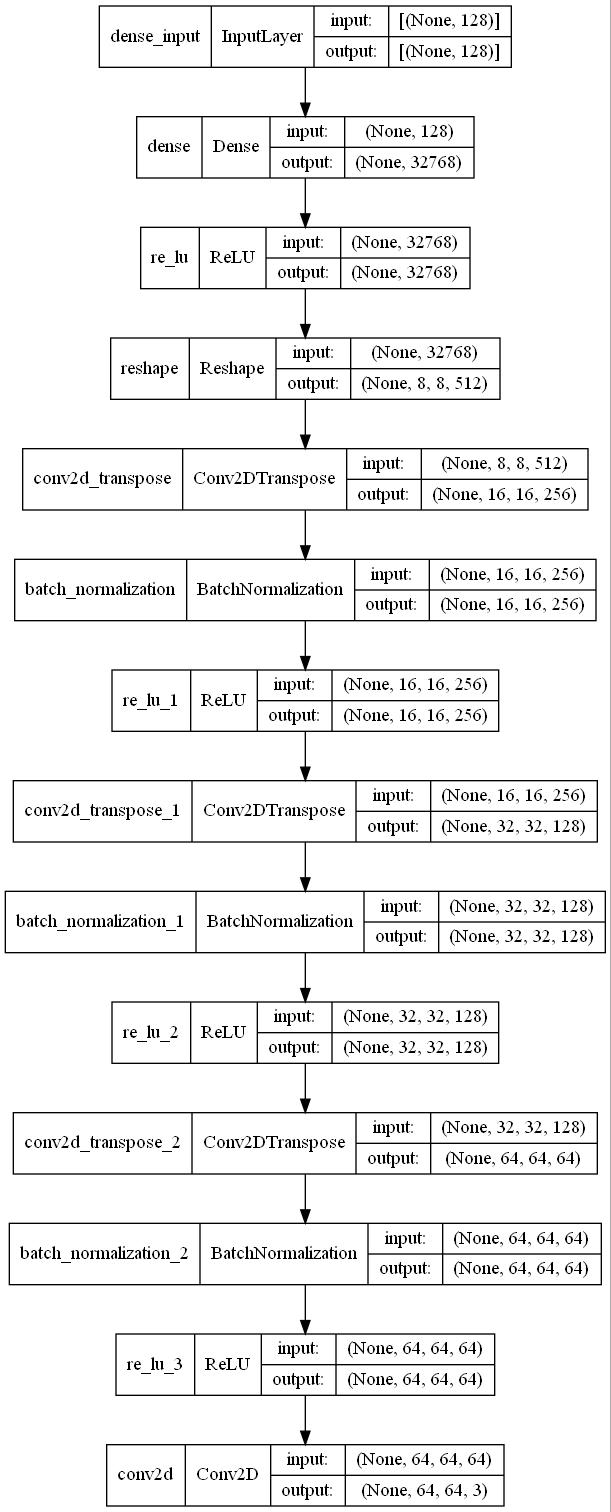

In [12]:
from tensorflow.keras.utils import plot_model
plot_model(generator, show_shapes=True, show_layer_names=True, to_file='generator_ANIME.jpg')

In [13]:

class WeightClipping(tf.keras.constraints.Constraint):
    def __init__(self, clip_value):
        self.clip_value = clip_value
    
    def __call__(self, weights):
        return tf.clip_by_value(weights, -self.clip_value, self.clip_value)
    
    def get_config(self):
        return {'clip_value': self.clip_value}

In [14]:
def build_critic(height, width, depth, alpha=0.2):
    #UPDATE for WGAN: enfoce 1-Lipschitz constraint with weight clippping to [-1, 1] 
    constraint = WeightClipping(0.01)

    # create a Keras Sequential model
    model = Sequential(name="critic")
    input_shape = (height, width, depth)

    # 1. first set of CONV => BN => leaky ReLU layers
    model.add(layers.Conv2D(64, (4, 4), padding="same", 
                            strides=(2, 2),
                            kernel_constraint = constraint, # UPDATE for WGAN
                            input_shape=input_shape))
    # model.add(layers.BatchNormalization()) 
    model.add(layers.LeakyReLU(alpha=alpha))

    # 2. second set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (4, 4), padding="same", 
                            strides=(2, 2), 
                            kernel_constraint = constraint,)) # UPDATE for WGAN
    # model.add(layers.BatchNormalization()) 
    model.add(layers.LeakyReLU(alpha=alpha))

    # 3. third set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (4, 4), padding="same", 
                            strides=(2, 2),
                            kernel_constraint = constraint,)) # UPDATE for WGAN
    # model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # flatten and apply dropout
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3)) 

    # UPDATE for WGAN: linear activation in the last layer. 
    # Note: Keras `Dense` layer by default is already a `linear` activation
    model.add(layers.Dense(1, activation="linear"))

    # return the critic model
    return model

In [15]:
# build the critic model
critic = build_critic(64, 64, 3) 

In [16]:
critic.summary()

Model: "critic"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)              0    

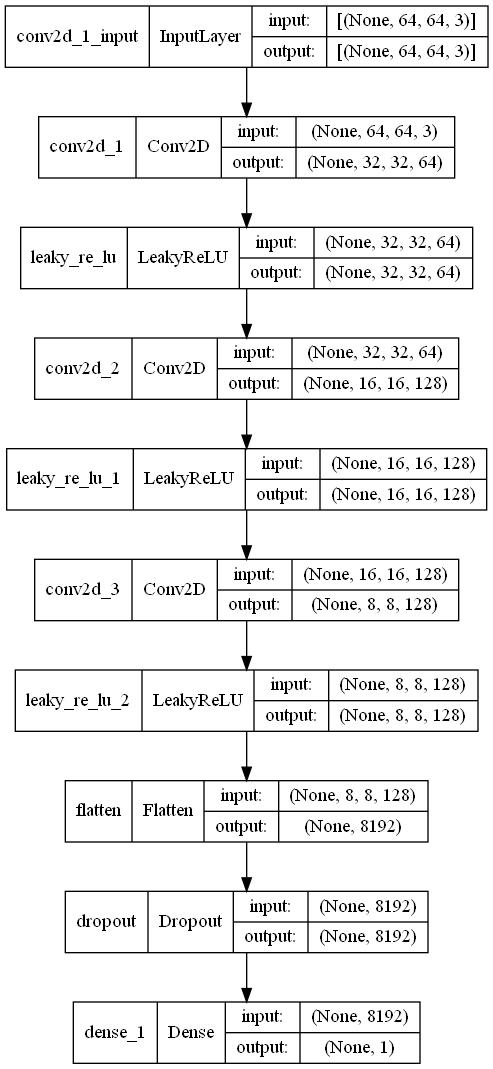

In [17]:
plot_model(critic, show_shapes=True, show_layer_names=True, to_file='critic_ANIME.jpg')

In [18]:
class WGAN(keras.Model):
    def __init__(self, 
                 critic, 
                 generator, 
                 latent_dim, 
                 critic_extra_steps): # UPDATE
        super().__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.c_extra_steps = critic_extra_steps
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    # UPDATE for WGAN: remove the code of real / fake labels
    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # UPDATE for WGAN: we train the critic more often than the generator by 5 times (self.c_extra_steps) 
        for i in range(self.c_extra_steps):
            # Step 1. Train the critic with both real images and fake images 
            with tf.GradientTape() as tape:
                # Get the critic' predictions on the real images
                pred_real = self.critic(real_images, training=True)
                # Generate fake images from the latent noise
                fake_images = self.generator(noise, training=True) 
                # Get the critic' predictions on the fake images
                pred_fake = self.critic(fake_images, training=True)
                # Calculate the critic loss with wassertein loss function
                d_loss = self.d_loss_fn(pred_real, pred_fake)
            # Compute critic gradients
            grads = tape.gradient(d_loss, self.critic.trainable_variables)
            # Update critic weights
            self.d_optimizer.apply_gradients(zip(grads, self.critic.trainable_variables))

        # Step 2. Train the generator (do not update weights of the critic)
        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training=True)
            pred_fake = self.critic(fake_images, training=True)
            g_loss = self.g_loss_fn(pred_fake) 
        # Compute generator gradients
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update generator weights
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [19]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

        # Create random noise seed for visualization during traing
        self.seed = tf.random.normal([16, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generator(self.seed)
        generated_images = (generated_images * 127.5) + 127.5
        generated_images.numpy()

        fig = plt.figure(figsize=(4, 4))
        for i in range(self.num_img):
            plt.subplot(4, 4, i+1)
            img = keras.utils.array_to_img(generated_images[i]) 
            plt.imshow(img)
            plt.axis('off')
        plt.savefig('epoch_{:03d}.png'.format(epoch)) 
        plt.show()

    def on_train_end(self, logs=None):
        self.model.generator.save('generator_anime.h5')

In [20]:
wgan = WGAN(critic=critic, 
              generator=generator, 
              latent_dim=LATENT_DIM,
              critic_extra_steps=5)

In [21]:
# Wasserstein loss for the critic
def d_wasserstein_loss(pred_real, pred_fake):
    real_loss = tf.reduce_mean(pred_real)
    fake_loss = tf.reduce_mean(pred_fake)
    return fake_loss - real_loss

# Wasserstein loss for the generator
def g_wasserstein_loss(pred_fake):
    return -tf.reduce_mean(pred_fake)

In [22]:
LR = 0.00005

In [23]:
wgan.compile(
    d_optimizer = keras.optimizers.RMSprop(learning_rate=LR, clipvalue=1.0, decay=1e-8), # UPDATE for WGAN: use RMSProp instead of Adam
    g_optimizer = keras.optimizers.RMSprop(learning_rate=LR, clipvalue=1.0, decay=1e-8), # UPDATE for WGAN: use RMSProp instead of Adam
    d_loss_fn = d_wasserstein_loss,
    g_loss_fn = g_wasserstein_loss
)

Epoch 1/50
497/497 [==============================] - ETA: 0s - d_loss: -1836446.0000 - g_loss: -11935.5557

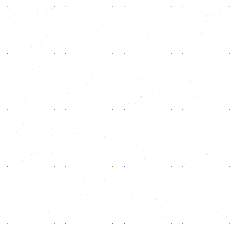

497/497 [==============================] - 279s 558ms/step - d_loss: -1836446.0000 - g_loss: -11935.5557
Epoch 2/50
 54/497 [==>...........................] - ETA: 4:13 - d_loss: -3904495.7500 - g_loss: -25723.3223

KeyboardInterrupt: 

In [26]:
NUM_EPOCHS = 50 # number of epochs
wgan.fit(train_images, epochs=NUM_EPOCHS, callbacks=[GANMonitor(num_img=16, latent_dim=LATENT_DIM)])

## PART 2_ USE THE GENERATOR

first we will try WGAN model....

In [27]:
from tensorflow.keras.models import load_model
noise = tf.random.normal(shape=(1, 128))
gen=load_model('generator_wgan.h5')

In [28]:
A=gen.predict(noise)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


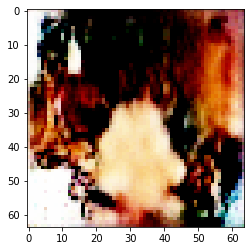

In [29]:
plt.figure()
plt.imshow(A[0], cmap='gray')
plt.show()

Now it is time for WGANGP with same noise...

In [30]:

gen_GP=load_model('generator_wgangp.h5')


In [33]:
B=gen_GP.predict(noise)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


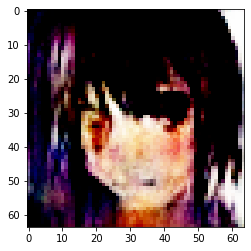

In [35]:
plt.figure()
plt.imshow(B[0], cmap='gray')
plt.show()

REFERENCES : 

Maynard-Reid, M. “Anime Faces with WGAN and WGAN-GP,” PyImageSearch, 2022, https://pyimg.co/9avys

https://arxiv.org/pdf/1701.07875.pdf